# Stochastic Differential Equations, Quantum Phase Space, and Julia 

$$
\def\julia{\texttt{julia}}
\def\dashint{{\int\!\!\!\!\!\!-\,}}
\def\infdashint{\dashint_{\!\!\!-\infty}^{\,\infty}}
\def\D{\,{\rm d}}
\def\E{{\rm e}}
\def\dx{\D x}
\def\dt{\D t}
\def\dz{\D z}
\def\C{{\mathbb C}}
\def\R{{\mathbb R}}
\def\CC{{\cal C}}
\def\HH{{\cal H}}
\def\I{{\rm i}}
\def\qqqquad{\qquad\qquad}
\def\qqfor{\qquad\hbox{for}\qquad}
\def\qqwhere{\qquad\hbox{where}\qquad}
\def\Res_#1{\underset{#1}{\rm Res}}\,
\def\sech{{\rm sech}\,}
\def\vc#1{{\mathbf #1}}
$$

Dr. Ashton Bradley
<br>
ashton.bradley@otago.ac.nz
<br>
http://amoqt.otago.ac.nz

## Workshop 2 (1 hour) 
- Numerical Wiener process
- Intro to `DifferentialEquations.jl`

References
- _An algorithmic introduction to numerical simulation of stochastic differential equations_, D. J. Higham, [SIAM Review, __43__, 525-546 (2001)](https://epubs.siam.org/doi/abs/10.1137/S0036144500378302)

# Wiener process
The _Wiener process_ $W(t)$, depending continuously on $t\in[0,T]$, has the following defining properties:
1. $W(0)=0$ (with probability 1).
2. For $0\leq s<t\leq T$ the random variable given by the increment $W(t)-W(0)$ is normally distributed with mean zero and variance $t-s$. 
3. For $0\leq s<t<u<v\leq T$ the increments $W(t)-W(s)$ and $W(v)-W(u)$ are independent. 

Property 2 is the statement that the Wiener process can be described by a normal random variable:

>$W(t)-W(s)\sim \sqrt{t-s}N(0,1)$, where $N(0,1)$ is a scaled Gaussian random variable with mean zero and unit variance. In $\julia$ this is `randn()`.

Property 3 is the statement that the Wiener process is a _Markov process_ (memoryless).

The Wiener process is often referred to as simply ___Brownian motion___ since it is the fundamental process governing Brownian motion as derived by Einstein, with diffusion coefficient $D\equiv 1$.

# Computational Wiener process
On a computer we always deal with discretizations. The discretized Brownian motion is equivalent to a set of samples from `randn()` 

In [1]:
using Statistics, Plots, LaTeXStrings, Revise
gr(grid=false,legend=false,size=(400,200),titlefontsize=12)

Plots.GRBackend()

In [2]:
linspace(a,b,n) =  LinRange(a,b,n) |> collect #linspace is worth having

linspace (generic function with 1 method)

In [3]:
randn() # part of base julia

-0.771632552513636

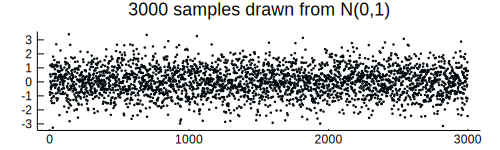

In [16]:
N = 3000
x = randn(N)
n = 1:N |> collect # convert a range object to a vector
plot(n,x,seriestype=:scatter,ms=.5,size=(500,150))
title!("$N samples drawn from N(0,1)")

In [17]:
mean(x),var(x) # from the Statistics package

(0.013675808381623569, 1.0274862868218058)

In [18]:
T = 1; N = 500; dt = T/N
t = linspace(0,T,N+1)
W = zeros(N)
ΔW = sqrt(dt)*randn(N); #all independent

In [19]:
mean(ΔW), var(ΔW), dt, length(t)

(-0.003350485212129419, 0.0019263381426500564, 0.002, 501)

We single the initial condition out as a special point with index $j=0$, and use the discretized definition

$ W_j\equiv W_{j-1} + ΔW_j$

with $j=1,2,..., N$. This choice is consistent with julia's "1-indexing" of arrays.

In [20]:
W[1] = ΔW[1] 
for j in 2:N 
    W[j] = W[j-1] + ΔW[j]
end
W = [0.0; W]; # careful here! - in jupyter we can do out of order execution

In [21]:
mean(W), length(W)

(-0.7420652941019694, 501)

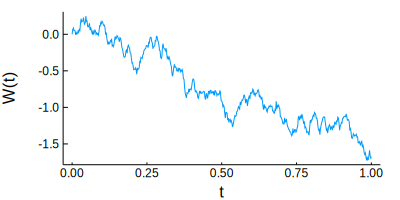

In [22]:
dt = T/N
plot(t,W)
xlabel!("t");ylabel!("W(t)")

Let's deal with the sampling and initial condition inside a single function that samples one path, for `N` steps. 

We can also easily add a short documentation string to explain the function. This gives an example of documentation conventions and notation.

In [11]:
"""
`t,ΔW,W = wienerpath(N,T)`

Sample a path of the Wiener process over time interval `[0,T]` for `N` increments `ΔW` and initial condition `W(t=0)=W[1]=0.0`. 

Outputs:

- `t` time vector, of length `N+1`
- `ΔW` vector of increments, of length `N`
- `W` vector of `W[j]` at time points `t=t_j` with `j=1,2,...,N` corresponding to increments. The initial value is included, giving a vector of length `N+1`.
"""
function wienerpath(N,T)
    dt = T/N
    t = 0:dt:T |> collect
    dW = sqrt(dt)*randn(N)
    W = cumsum(dW)
    W = [0.0;W]
    return t,dW,W
end

wienerpath

The function is now part of our current julia session, and the documentation is also part of julia:

In [12]:
?wienerpath

search: wienerpath



`t,ΔW,W = wienerpath(N,T)`

Sample a path of the Wiener process over time interval `[0,T]` for `N` increments `ΔW` and initial condition `W(t=0)=W[1]=0.0`. 

Outputs:

  * `t` time vector, of length `N+1`
  * `ΔW` vector of increments, of length `N`
  * `W` vector of `W[j]` at time points `t=t_j` with `j=1,2,...,N` corresponding to increments. The initial value is included, giving a vector of length `N+1`.


We can also save the same code to a file, say `wienerpath.jl`, and load it by executing the command
`include("wienerpath.jl")`

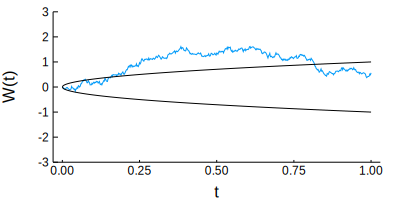

In [13]:
N = 500
t,ΔW,W = wienerpath(N,1)
p1=plot(t,W)
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
ylims!(-3,3);xlabel!("t");ylabel!("W(t)")

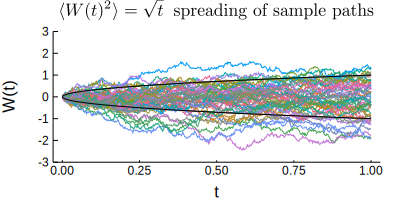

In [14]:
Np = 50
for j = 1:Np
    t,ΔW,W = wienerpath(N,1)
    plot!(p1,t,W,legend=false)
end
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
title!(L"\langle W(t)^2\rangle=\sqrt{t}\;\; \textrm{spreading of sample paths}")

Let's make a simple animated `.gif` of wienerpaths:

In [ ]:
N = 500
t,ΔW,W = wienerpath(N,1)
p1 = plot(t,W)
plot!(t,sqrt.(t),linewidth=1,c=:black)
plot!(t,-sqrt.(t),linewidth=1,c=:black)
ylims!(-3,3);xlabel!("t");ylabel!("W(t)")

anim = @animate for i=1:150
t,ΔW,W = wienerpath(N,1)
plot!(p1,t,W)
end

gif(anim,"media/wpaths.gif", fps = 12)

# FPE solution for Brownian motion
The diffusion equation

$$\frac{\partial p(x,t|0,0)}{\partial t}=\frac{1}{2}\frac{\partial^2p(x,t|0,0)}{\partial x^2}$$

with ideally localized initial condition $p(x,t=0|0,0) = n\delta(x)$ has solution

$$p(x,t|0,0)=\frac{n}{\sqrt{2\pi t}}e^{-x^2/2t}$$

In [ ]:
p(x,t) = exp(-x^2/(2t))/sqrt(2π*t) #scalar definition

In [ ]:
y = linspace(-2,2,500)
heatmap(t,y,p.(y,t'),size=(600,200),transpose=false) # broadcast
plot!(t,sqrt.(t),linewidth=1,c=:white)
plot!(t,-sqrt.(t),linewidth=1,c=:white)
xlims!(0,.5);ylims!(-2,2)

In [ ]:
# another plot example
p1=surface(t,y,p.(y,t'),color = :rainbow,size=(400,300))
plot!(p1, camera=(40, 40))

# Ensemble average
Let's compute a simple stochastic average over our Wiener increments. 

We can graph the sample average for a set of sample paths of the Wiener process. 

- We show the average, and a few sample paths, of the function $f(t)=e^{t+W(t)/2}$. 
- The known analytic result for the mean is $\langle f(t)\rangle =e^{9t/8}$.

In [ ]:
T = 1; N = 500; Δt = T/N 
t = linspace(0,T,N+1)
Np = 1000
ΔW = sqrt(Δt)*randn(N,Np)
W = cumsum(ΔW,dims=1)
W = [zeros(1,Np); W]
U = @. exp(t + 0.5*W) # broadcast (!!)
Ū = mean(U,dims=2) # path average at each time
plot(t,U[:,1:3],s=:dot,size=(500,300)) # show a few paths
plot!(t,Ū,w=8,c=:lightgrey,label="mean of $Np paths",legend=:topleft)
plot!(t,exp.(9t/8),w=2,c=:blue,label=L"e^{9t/8}\;\;\textrm{(analytic)}")
xlabel!(L"t");ylabel!(L"W(t)")
title!(L"\langle e^{t+W(t)/2}\rangle")

## Theorem
If $u$ is a Gaussian variable with mean $\langle u\rangle =0$ and variance $\langle u^2\rangle=\sigma^2$, then 

$$ \langle e^{\alpha u}\rangle = e^{\alpha^2\sigma^2/2}$$

__Exercise:__ use this to prove the analytic result for $\langle f(t)\rangle$ given above.

# Differential Equations
Chris Rackauckas (recent Math PhD at UC Irvine, now Postdoc at MIT) has written an ___utterly astonishing___ differential equation solving package in $\julia$.
- He is an expert on SDE's, expert programmer and $\julia$ whiz.
- Wanted to compare results for different SDE methods and problems
- Realized there was no decent package for numerical solving
- `DifferentialEquations.jl` is now world-leading in every aspect of numerical solving
- State of the art adaptive stochastic integration methods, only published 2018 (now being copied by other libraries).
- See also his blog [Stochastic Lifestyle](http://www.stochasticlifestyle.com/) for some really nice resources for learning more about $\julia$.
- See a comparison [here](http://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/)

To compare with library of similar convenience, for a small problem (comparable to predator-prey considered below) how does it compare with Matlab's ODE45?

<img src="media/comparison.png" width="600">

Yes - that is that two orders of magnitude!

In [ ]:
using DifferentialEquations, Statistics, Plots, LaTeXStrings, Revise
gr(grid=false,legend=false,size=(400,200),titlefontsize=12)
linspace(a,b,n) = LinRange(a,b,n) |> collect

# A cute example: predator-prey model

## Equations of motion
The **Lotka-Volterra equations** for this system take the form:
<div class="alert alert-block alert-warning">
<font color=blue>
\begin{align}
\frac{dr}{dt}&=\lambda r - \gamma wr\\
\frac{dw}{dt}&=-\beta w + \sigma rw 
\end{align}
</font>
</div>
The solutions of this two-variable system of coupled nonlinear equations tells us everything about our simple model for population dynamics.  

In [ ]:
#\:rabbit2: = 🐇 #remember to tab-complete 
#\:wolf: = 🐺
#\lambda<tab> = λ #etc

In [ ]:
#system parameters
λ = .7  # 🐇 growth
γ = 0.4  # 🐇 loss
σ = 0.3  # 🐺 growth
β = 1.2  # 🐺 loss

#define the equations of motion (standard first order form)
#in-place vector syntax
function predatorprey!(du,u,p,t)
    du[1] =  p[1]*u[1] - p[2]*u[2]*u[1]
    du[2] = -p[3]*u[2] + p[4]*u[1]*u[2]
    return nothing  #good practice if the function is mutating
end

the function signature (first line) shows the required form 
if you are writing your own function to pass to DifferentialEquations. In this "in-place form", you have to first declare the place the differentials are written to (`du`), then declare the unknown fields (`u`), then a set of parameters (`p`), and finally time `t`. Note that in our equatnions of motion (EOM), we don't make use of `t`, and in general it is not a requirement that `p` is used either, just that the function signature has this general form. For the "out-of-place" form, this would become `predatorprey(u,p,t)`, and we would need to replace `return nothing` with `return x`, where `x` is the result of evaluating the right hand side of our EOM.

Define EOM using a macro from [ParameterizedFunctions.jl](https://github.com/JuliaDiffEq/ParameterizedFunctions.jl)

In [ ]:
pprey = @ode_def_all LotkaVolterra begin
  d🐇 = λ*🐇 - γ*🐺*🐇
  d🐺 = -β*🐺 + σ*🐇*🐺
end λ γ β σ

The macro writes a bunch of methods with the right syntax to pass to `DifferentialEquations` using your declared set of unknowns. Note that the unknowns are declared implicitly by stating the equations. Again, the syntax is that you should write `dx = ...` for each equation of motion, dropping the redundant `dt` that would appear on the right hand side if this was a rigorous mathematical statement of your equations of motion. 
    

# Fixed point
Let us first verify that if we start at a known fixed point, 
it really _is_ a stationary solution 

In [ ]:
r̄ = β/σ
w̄ = λ/γ
u0 = [r̄ ; w̄]
ti = 0.0
tf = .2
Nt = 100
tspan = (ti,tf)
t = linspace(ti,tf,Nt) 
params = [λ; γ; β; σ]

#define the problem type
prob = ODEProblem(pprey,u0,tspan,params)

First call triggers the just in time compiler (JIT)

In [ ]:
#solve the problem, saving at specified time points
@time sol = solve(prob,saveat=t);

The solution time for compiled code:

In [ ]:
#solve the problem, saving at specified time points
@time sol = solve(prob,saveat=t);

In [ ]:
🐇 = sol[1,:]; 🐺 = sol[2,:]
plot(t,🐇,label="rabbits",legend=:topright);plot!(t,🐺,label="wolves")
ylims!(0,8);xlabel!("t");ylabel!("population")

In [ ]:
#parameters
λ = .7  # 🐇 growth
γ = 0.4  # 🐇 loss
σ = 0.3  # 🐺 growth
β = 1.2  # 🐺 loss
params = [λ; γ; β; σ]
r̄ = β/σ; w̄ = λ/γ

#what happens if the rabbits and wolves start near, but not exactly at, a fixed point?
ϵ = .1
u0 = [β/σ + ϵ ; λ/γ - ϵ] #one slightly larger, one slightly smaller
ti = 0.0
tf = 50.0
Nt = 200
tspan = (ti,tf)
t = linspace(ti,tf,Nt) 

prob = ODEProblem(pprey,u0,tspan,params)
@time sol = solve(prob,saveat=t);

In [ ]:
🐇 = sol[1,:]; 🐺 = sol[2,:]
plot(t,🐇,label=L"r(t)",legend=:topright);plot!(t,🐺,label=L"w(t)")
plot!(t,r̄*one.(t),label=L"\bar r",s=:d)
plot!(t,w̄*one.(t),label=L"\bar w",s=:d)
ylims!(0,5);xlabel!("t");ylabel!("population")
xlims!(0,70)

Great. Let's say we want to study behavior as a function of how far the populations start from the steady state. 

We wrap the above inside a fuction (let's avoid global scope and simplify):

In [ ]:
function pprey_shift(ϵ)
#parameters
λ = .7  # 🐇 growth
γ = 0.4  # 🐇 loss
σ = 0.3  # 🐺 growth
β = 1.2  # 🐺 loss
params = [λ; γ; β; σ]

u0 = [β/σ + ϵ ; λ/γ - ϵ] #one slightly larger, one slightly smaller
ti = 0.0
tf = 50.0
Nt = 200
tspan = (ti,tf)
t = linspace(ti,tf,Nt) 

prob = ODEProblem(pprey,u0,tspan,params)
sol = solve(prob,saveat=t);
🐇 = sol[1,:]; 🐺 = sol[2,:]
    return 🐇, 🐺
end

In [ ]:
using Interact

In [ ]:
ϵmax = 1.2
Neps = 20
ϵvec = linspace(0.0,ϵmax,Neps)

p1=plot(size=(600,200))
@manipulate for ϵ in ϵvec 
    🐇, 🐺 = pprey_shift(ϵ)
    plot(t,🐇,label=L"r(t)",legend=:topright);plot!(t,🐺,label=L"w(t)")
    plot!(t,r̄*one.(t),label=L"\bar r",s=:d)
    plot!(t,w̄*one.(t),label=L"\bar w",s=:d)
    ylims!(0,5);xlabel!("t");ylabel!("population")
    xlims!(0,70);ylims!(0,8)
    title!("predator-prey dynamics")
end

Fast enough to run and plot in real time scanning parameter space. If the slider feels a little clunky at times, it is because it is running every simulation along the way and plotting the last one that you stop at (efficiency of interact isn't such a priority for $\julia$ developers at the moment!)

# Workshop 3
- Quantum phase space with SDE's